# Preparing the Data #

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
filename = 'PATH TO ZOOM LOG FILE'

zoom = pd.read_csv(filename, 
                   header=2, 
                   usecols=['Participant', 'Join Time', 'Leave Time']
                  )

# The headers for the columns we want are on the 2 index row, the default headers will
# contain the general meeting information (ID, Topic, Host, Start Time, etc.), whereas
# the actual logs start lower down. So we use header=2 and usecols to select the rele-
# -vant columns

In [3]:
zoom['Leave Time'] = [str(x)[0:8] for x in zoom['Leave Time']]

# The times in the 'Leave Time' column have the 'reason' attached, ex: 
# 05:04 PM(X left the meeting.Reason: left the meeting), so we have to remove these
# characters with a list comprehension

# DataFrame: Join and Leave of Each Participant #

In [4]:
def JoinsAndLeaves(dF):

    leave_times = []

    for l in dF['Leave Time']:
        l = str(l).replace(':', '')
        if l[0] == '0':
            ll = l[1:]
        if l[-2:] == 'PM':
            l=l[:-2]
            if int(l) < 1200:
                l = int(l) + 1200
        else:
            l=l[:-2]
        leave_times.append(int(l))

    dF['Leave Time'] = leave_times

    join_times = []

    for j in dF['Join Time']:
        j = str(j).replace(':', '')
        if j[-2:] == 'PM':
            j=j[:-2]
            if int(j) < 1200:
                j = int(j) + 1200
        else:
            j=j[:-2]
        join_times.append(int(j))

    dF['Join Time'] = join_times

    # Converting all the string times, '05:04 PM', to integers that we can do math with, 
    # essentially military time without leading zeroes. 

    participants = dF.groupby('Participant')

    # Because zoom notes a person as having left the meeting whenever they've selected a tab
    # other than the zoom meeting, each person will have several different entries in the log
    # we perform a groupby function here to gather all of them in one place, then choosing the
    # earliest join and latest leave as markers for when they truly joined and left the meeting.

    joins_and_leaves = pd.DataFrame({
        'First Join' : participants['Join Time'].min(),
        'Last Leave' : participants['Leave Time'].max(),
    })
    
    return joins_and_leaves

In [5]:
joins_and_leaves = JoinsAndLeaves(zoom)
joins_and_leaves

,First Join,Last Leave
Participant 0,959,1746
Participant 1,1648,1701
Participant 2,1100,1713
Participant 3,1101,1713
Participant 4,1034,1140
...,...,...
Participant 370,1307,1422
Participant 371,1100,1538
Participant 372,1509,1712
Participant 373,1100,1629


# Visualization: Concurrent Participants #

In [6]:
# Function for creating the concurrent participants graph from the DataFrame we've prepared.
# The interval argument can go from 1-60 (minutes), and determines how granular the final 
# graph is. With a value of 1, there will be a bar for each minute of the meeting. 

def ActiveGraph(dF, interval=1):

    times = []
    
    first_hour = (dF['First Join'].min() // 100) * 100
    last_hour = ((dF['Last Leave'].max() // 100) + 1) * 100
    
    # variables for bounding the graph, finds the earliest join instance and sets to 
    # the top of that hour. Then finds the latest leave instance and sets to the top of 
    # the following hour.
    
    for x in range(first_hour, last_hour, 100):
        for y in range(0, 60, interval):
            times.append(x+y)
            
    # Loop that creates all the times to be checked based on the first hour, last hour
    # and interval parameters

    active = [0 for x in times]
    
    # initiatializes are list of active participants corresponding to each time. For
    # now all values are zero.

    for i in range(len(dF['First Join'])):
        join = dF.iloc[i]['First Join']
        leave = dF.iloc[i]['Last Leave']

        for t in times:
            if join < t and leave > t:
                active[(times.index(t))] += 1
                
    # These nested for loops go through each row in our DataFrame and add 1 to each
    # time that is between the join and leave time associated with that row, giving
    # us the number of concurrent participants at each time

    pd.DataFrame({
        'Time': times,
        'Active' : active
    }).set_index('Time').plot(kind='bar', figsize=(15, 10))
    
    # Creates a DataFrame out of our times and active participant counts, enabling
    # us to create the graph in the same line of code.
    
    labels = []
    for i in range((first_hour//100), (last_hour//100)+1, 1):
        labels.append(i)
    labels = [(str(x-12) + ' PM') if x>12 else (str(x) + ' AM') for x in labels]
    
    # Creates a list of our tick labels, which include every hour the meeting is active.

    plt.xticks(np.arange(0, len(times)+0.01, 60/interval), labels, rotation='horizontal')
    
    # this numpy range gives us the tick locations for each hour.

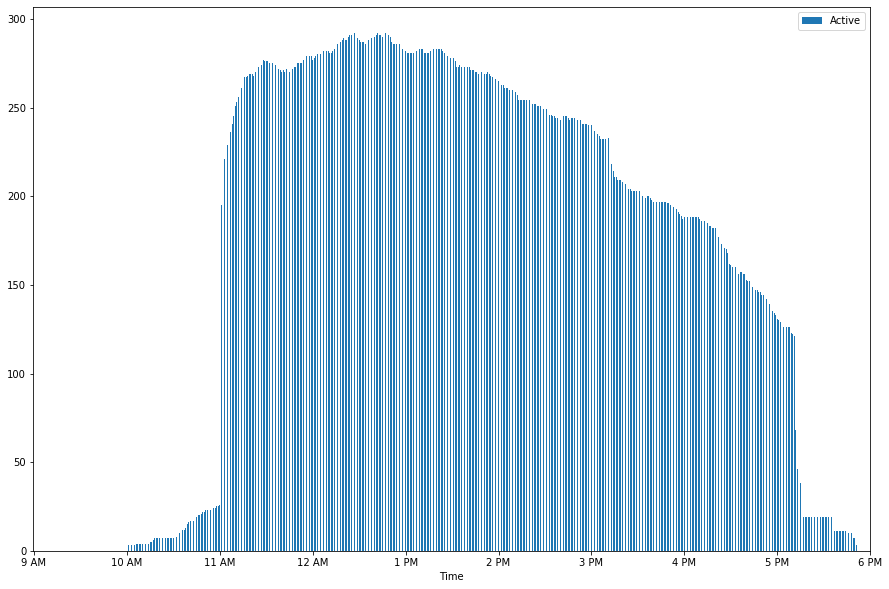

In [7]:
ActiveGraph(joins_and_leaves, interval=1)

# DataFrame: Total Attendance Time #

In [8]:
def AttendanceTime(dF):
    
    att_time = []

    for i in range(len(dF['First Join'])):
        join = dF.iloc[i]['First Join']
        leave = dF.iloc[i]['Last Leave']
        
        hour = (leave//100 - join//100) * 100
        minute = (leave-((leave//100)*100)) - (join-((join//100)*100))
        
        if minute < 0 :
            minute -= 40

        duration = hour+minute
        
        att_time.append(duration)
        
    dF['Total Time'] = att_time
    
    return dF.sort_values(by='Total Time', ascending=False)
    

In [8]:
AttendanceTime(joins_and_leaves)

,First Join,Last Leave,Total Time
Participant 330,959,1752,753
Participant 88,1000,1752,752
Participant 0,959,1746,747
Participant 193,1016,1737,721
Participant 299,1017,1737,720
...,...,...,...
Participant 134,1329,1333,4
Participant 103,1127,1129,2
Participant 344,1244,1246,2
Participant 341,1115,1116,1


# Visualization: Duration of Attendance #

In [9]:
def DurationGraph(dF):
    
    first_hour = (dF['First Join'].min() // 100) * 100
    last_hour = ((dF['Last Leave'].max() // 100) + 1) * 100
    
    labels = []
    ticks =[]
    
    for i in range(first_hour, last_hour+1, 100):
        ticks.append(i)
        labels.append(i//100)
    labels = [(str(x-12) + ' PM') if x>12 else (str(x) + ' AM') for x in labels]
    
    # Dynamically finding our tick labels based on the data
    
    mpl.rc('xtick', labelsize=12) 
    mpl.rc('ytick', labelsize=15) 

    plt.figure(figsize=(15, 10))
    plt.hlines(np.arange(len(dF.index)), 
               dF['First Join'], 
               dF['Last Leave'], 
               color='g', 
               lw = 4,
              )
    
    # Plotting the initial horizontal line graph

    y = np.arange(len(dF.index))
    
    plt.vlines(dF['First Join'], y+0.1, y-0.1, color='b', lw=2)
    plt.vlines(dF['Last Leave'], y+0.1, y-0.1, color='r', lw=2)
    
    # Creating the vertical 'join' and 'leave' lines at the end of each horizontal bar

    plt.yticks(y, dF.index.to_list())
    plt.xticks(ticks,labels)
    
    # Putting into place the x and y ticks
    

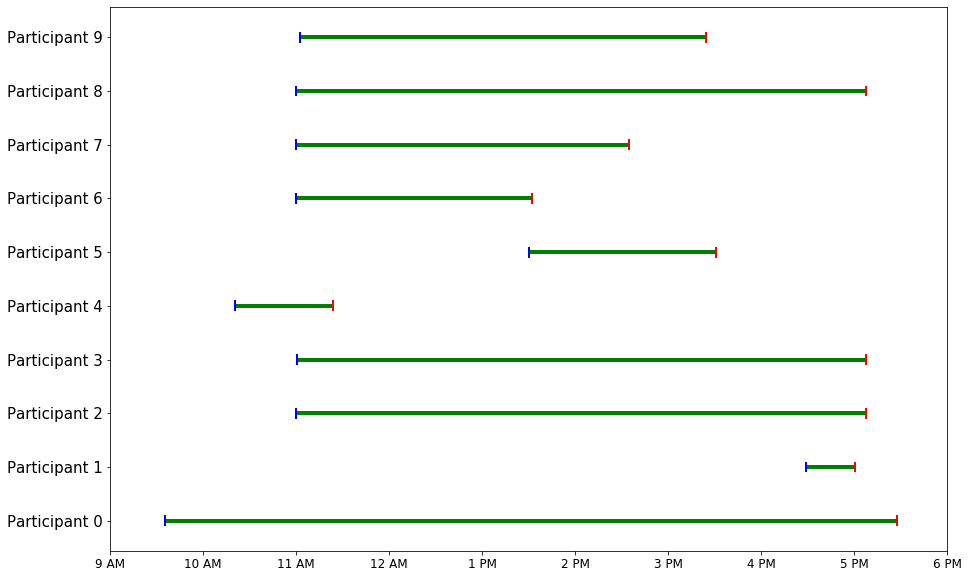

In [10]:
DurationGraph(joins_and_leaves.head(10))